In [1]:
import cv2
from PIL import Image
import random
import os, glob
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import torch
import torch.nn as nn

from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn.functional as F

from tqdm.autonotebook import tqdm

In [8]:
device = 'cuda'
batch_size = 64
num_workers = 4
lr = 1e-3
momentum = 0.9
weight_decay = 1e-5
epoch = 20
n_steps = 10000

In [26]:
from torch.utils.data import DataLoader, RandomSampler

# Data transformation of train and test data
data_transforms = {
    'train': transforms.Compose([
        # build your own transforms
        transforms.Pad(4),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomCrop(128),
        transforms.RandomRotation(0.4),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ]),
}

train_dataset = datasets.ImageFolder('Linnaeus 5 128X128/train', transform=data_transforms['train'])
test_dataset = datasets.ImageFolder('Linnaeus 5 128X128/test', transform=data_transforms['test'])

sampler = RandomSampler(train_dataset,
                        replacement=True,
                        num_samples=batch_size * n_steps)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              sampler=sampler, num_workers=num_workers, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False, num_workers=num_workers)


print(len(train_dataset)) # b , 3, 64, 64
print(len(test_dataset))

3600
1200


Size of train set: 3600
Input shape: torch.Size([3, 128, 128])
Label: 2


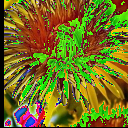

In [30]:
# Let's take a look at train dataset
print(f"Size of train set: {len(train_dataset)}")
index = 2400
x, y = train_dataset[index]
print(f"Input shape: {x.shape}")
print(f"Label: {y}")

transforms.functional.to_pil_image(x)

In [32]:
# Minimal MLP implementation
# DO NOT CHANGE Model name

class block(nn.Module):
    def __init__(self, dim_1, dim_2, stride=1):
        super(block, self).__init__()
        self.conv1 = nn.Conv2d(dim_1, dim_2, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(dim_2)
        self.conv2 = nn.Conv2d(dim_2, dim_2, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(dim_2)

        self.shortcut = nn.Sequential()
        if stride != 1 or dim_1 != dim_2:
            self.shortcut = nn.Sequential(
                nn.Conv2d(dim_1, dim_2, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(dim_2)
            )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)  



    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Model(nn.Module):
    def __init__(self, num_classes=3):
        super(Model, self).__init__()
        self.in_dim = 128

        self.conv1 = nn.Conv2d(3, self.in_dim, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_dim)
        self.layer1 = self._make_layer(32*2, 2, stride=1)
        self.layer2 = self._make_layer(32*4, 2, stride=2)
        self.layer3 = self._make_layer(32*8, 2, stride=2)
        self.layer4 = self._make_layer(32*8, 2, stride=2)
        self.layer5 = self._make_layer(32*16, 2, stride=2)

        self.clf = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)), 
                                        nn.Flatten(), 
                                        nn.Linear(32*16, num_classes),
                                        nn.LogSoftmax(dim=-1))

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_dim, planes, stride))
            self.in_dim = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.clf(out)

        return out

In [33]:
Model()

Model(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [35]:
import numpy as np
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model = model
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
            self.best_score = score
            return self.best_model
        else:
            print(f'Validation loss decreased ({-self.best_score:.6f} --> {val_loss:.6f}).')
            self.best_score = score
            self.best_model = model
            # self.save_checkpoint(val_loss, model)
            self.counter = 0
            return self.best_model

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).')
        # torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [36]:
model = Model()
early_stopping = EarlyStopping(patience=5, verbose=True)
best_model = None
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
model = model.to(device)

for step, (x, y) in enumerate(tqdm(train_dataloader), start=1):
    model.train()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    pred = model(x)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()
    scheduler.step()
    # Summary & Eval
    if step % 500 == 0:
        
        total, correct = 0, 0
        test_loss = 0
        model.eval()
        for x, y in tqdm(test_dataloader, leave=False):
            x, y = x.to(device), y.to(device)

            # Don't compute gradient during evaluation
            with torch.no_grad():
                pred = model(x)

            test_loss += criterion(pred, y) * x.shape[0]

            total += x.shape[0]
            correct += (pred.max(dim=1)[1] == y).sum()

        test_loss /= total
        accuracy = correct / total

        print(f"[Step {step}] train_loss: {loss.detach().squeeze():.2f}, test_loss: {test_loss:.2f}, test_accuracy: {accuracy:.4f}")

        best_model = early_stopping(test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
model = best_model

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

[Step 500] train_loss: 0.50, test_loss: 0.46, test_accuracy: 0.7900
Validation loss decreased (inf --> 0.462823).


  0%|          | 0/19 [00:00<?, ?it/s]

[Step 1000] train_loss: 0.30, test_loss: 0.36, test_accuracy: 0.8658
Validation loss decreased (0.462823 --> 0.363695).


  0%|          | 0/19 [00:00<?, ?it/s]

[Step 1500] train_loss: 0.35, test_loss: 0.35, test_accuracy: 0.8525
Validation loss decreased (0.363695 --> 0.352710).


  0%|          | 0/19 [00:00<?, ?it/s]

[Step 2000] train_loss: 0.15, test_loss: 0.28, test_accuracy: 0.8975
Validation loss decreased (0.352710 --> 0.283638).


  0%|          | 0/19 [00:00<?, ?it/s]

[Step 2500] train_loss: 0.10, test_loss: 0.24, test_accuracy: 0.9225
Validation loss decreased (0.283638 --> 0.239971).


  0%|          | 0/19 [00:00<?, ?it/s]

[Step 3000] train_loss: 0.17, test_loss: 0.29, test_accuracy: 0.8892
EarlyStopping counter: 1 out of 5


  0%|          | 0/19 [00:00<?, ?it/s]

[Step 3500] train_loss: 0.07, test_loss: 0.31, test_accuracy: 0.8825
EarlyStopping counter: 2 out of 5


  0%|          | 0/19 [00:00<?, ?it/s]

[Step 4000] train_loss: 0.11, test_loss: 0.36, test_accuracy: 0.8975
EarlyStopping counter: 3 out of 5


  0%|          | 0/19 [00:00<?, ?it/s]

[Step 4500] train_loss: 0.00, test_loss: 0.27, test_accuracy: 0.9325
Validation loss decreased (0.362965 --> 0.271921).


  0%|          | 0/19 [00:00<?, ?it/s]

[Step 5000] train_loss: 0.00, test_loss: 0.27, test_accuracy: 0.9375
Validation loss decreased (0.271921 --> 0.265106).


  0%|          | 0/19 [00:00<?, ?it/s]

[Step 5500] train_loss: 0.16, test_loss: 0.54, test_accuracy: 0.8533
EarlyStopping counter: 1 out of 5


  0%|          | 0/19 [00:00<?, ?it/s]

[Step 6000] train_loss: 0.03, test_loss: 0.36, test_accuracy: 0.8942
Validation loss decreased (0.535600 --> 0.356832).


  0%|          | 0/19 [00:00<?, ?it/s]

[Step 6500] train_loss: 0.03, test_loss: 0.37, test_accuracy: 0.9000
EarlyStopping counter: 1 out of 5


  0%|          | 0/19 [00:00<?, ?it/s]

[Step 7000] train_loss: 0.01, test_loss: 0.38, test_accuracy: 0.9033
EarlyStopping counter: 2 out of 5


  0%|          | 0/19 [00:00<?, ?it/s]

[Step 7500] train_loss: 0.00, test_loss: 0.30, test_accuracy: 0.9308
Validation loss decreased (0.380419 --> 0.301309).


  0%|          | 0/19 [00:00<?, ?it/s]

[Step 8000] train_loss: 0.00, test_loss: 0.29, test_accuracy: 0.9325
Validation loss decreased (0.301309 --> 0.290542).


  0%|          | 0/19 [00:00<?, ?it/s]

[Step 8500] train_loss: 0.00, test_loss: 0.31, test_accuracy: 0.9375
EarlyStopping counter: 1 out of 5


  0%|          | 0/19 [00:00<?, ?it/s]

[Step 9000] train_loss: 0.00, test_loss: 0.30, test_accuracy: 0.9383
Validation loss decreased (0.309728 --> 0.301732).


  0%|          | 0/19 [00:00<?, ?it/s]

[Step 9500] train_loss: 0.00, test_loss: 0.31, test_accuracy: 0.9358
EarlyStopping counter: 1 out of 5


  0%|          | 0/19 [00:00<?, ?it/s]

[Step 10000] train_loss: 0.00, test_loss: 0.29, test_accuracy: 0.9392
Validation loss decreased (0.312004 --> 0.293532).


In [37]:
torch.save(model.state_dict(), './resnet_torch.pt')

In [108]:
def predict(x):
    x = x.to(device)
    
    with torch.no_grad():
        # You can modify this part if necessary
        pred = model(x)
        
    return pred.max(dim=1)[1].to('cpu')

In [109]:
def final_evaluation():
    model.eval()
    correct = 0
    for x, y in test_dataloader:
        correct += (predict(x) == y).sum()
    accuracy = correct / len(test_dataset)
    print(f"FINAL ACCURACY: {accuracy:.4f}")
    
final_evaluation()

FINAL ACCURACY: 0.9392


In [3]:
def divide_image(image):
    sub_blocks = []
    sub_block_height = 40
    sub_block_width = 40
    
    s_p = [0, 44, 88]
    
    for s_i in s_p:
        for s_j in s_p:
            start_x = s_j
            start_y = s_i
            end_x = start_x + sub_block_width
            end_y = start_y + sub_block_height
            sub_block = image[start_y:end_y, start_x:end_x, :]
            sub_blocks.append(sub_block)
    return sub_blocks

In [40]:
data = []
labels = []
div_data = []

height = 128
width = 128
channels = 3
num_classes = 3

path = f'Linnaeus 5 128X128/train/'
Class = os.listdir(path)
print(Class)
for i, a in enumerate(Class):
    data_path = f'Linnaeus 5 128X128/train/{a}/'
    data_list = os.listdir(data_path)
    for d in data_list:
        image = cv2.imread(data_path + d)
        image_from_array = Image.fromarray(image, 'RGB')
        img_arr = np.array(image_from_array)
        div_data.append(divide_image(image=img_arr))
        data.append(img_arr)
        labels.append(i)

data = np.array(data)
labels = np.array(labels)

['dog', 'bird', 'flower']


In [41]:
## test
test_data = []
test_labels = []
div_test_data = []

height = 128
width = 128
channels = 3
num_classes = 3

path = f'Linnaeus 5 128X128/test/'
Class = os.listdir(path)
print(Class)
for i, a in enumerate(Class):
    data_path = f'Linnaeus 5 128X128/test/{a}/'
    data_list = os.listdir(data_path)
    for d in data_list:
        image = cv2.imread(data_path + d)
        image_from_array = Image.fromarray(image, 'RGB')
        img_arr = np.array(image_from_array)
        div_test_data.append(divide_image(image=img_arr))
        test_data.append(img_arr)
        test_labels.append(i)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

['dog', 'bird', 'flower']


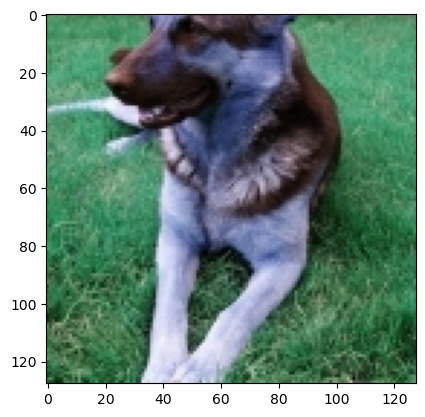

In [42]:
plt.imshow(test_data[0])

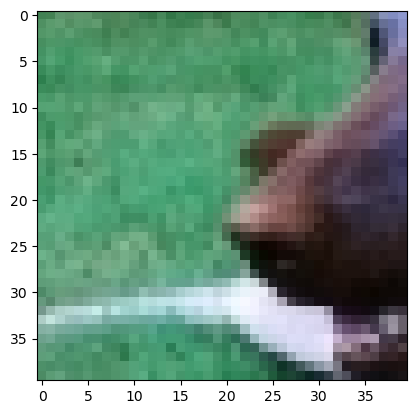

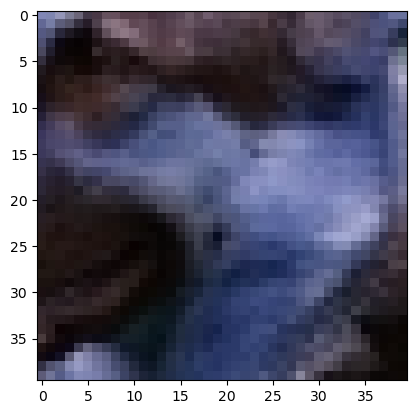

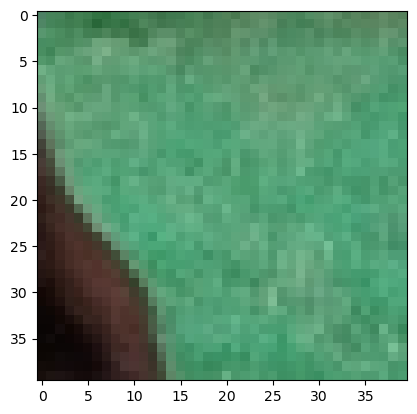

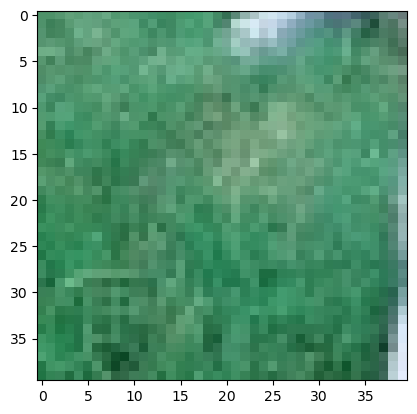

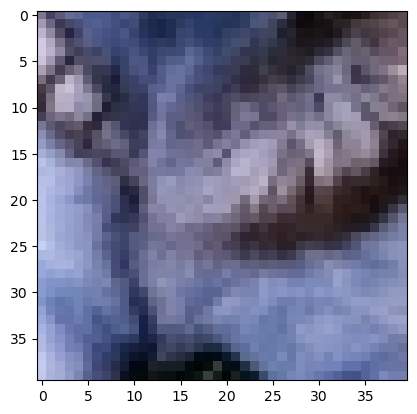

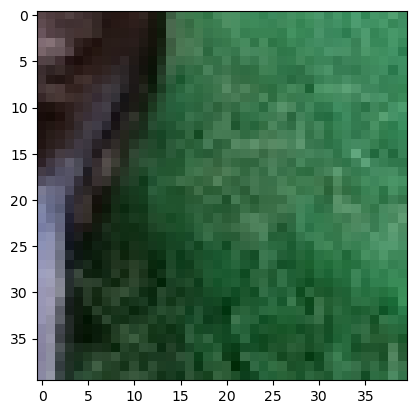

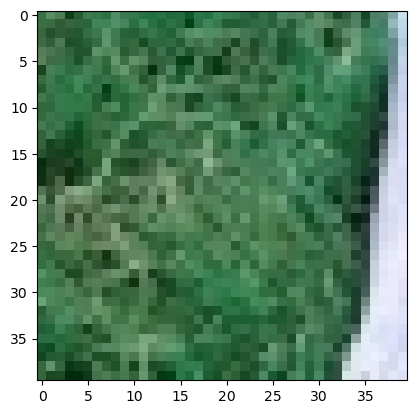

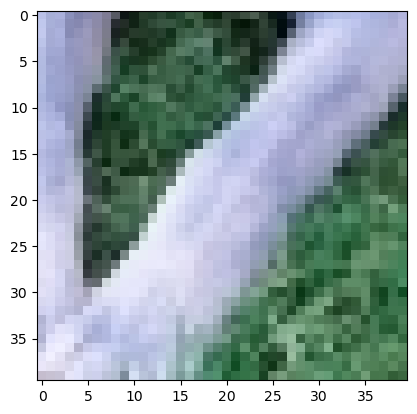

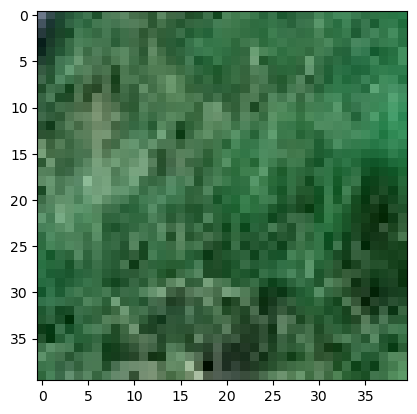

In [43]:
for im in np.array(div_test_data[0]):
    plt.figure()
    plt.imshow(im)


In [204]:
def reconstruct_image(combined_blocks):
    rows = []
    for i in range(0, 18, 3):
        row = np.concatenate(combined_blocks[i:i+3], axis=0)
        rows.append(row)
    merged_image = np.concatenate(rows, axis=1)
    return merged_image

def shuffle_blocks(blocks_a, blocks_b, l1, l2):
    shf_blocks = []
    mix_blocks = []
    mix_labels = []
    a_labels = [l1]*9
    b_labels = [l2]*9
    
    for b_a, b_b in zip(blocks_a, blocks_b):
        a_data = list(zip(b_a, a_labels))
        b_data = list(zip(b_b, b_labels))
        
        random.shuffle(a_data)
        random.shuffle(b_data)
        b_a_sh, b_a_label = zip(*a_data)
        b_b_sh, b_b_label = zip(*b_data)
        
        mixed_sub_block = b_a_sh + b_b_sh
        mixed_sub_labels = b_a_label + b_b_label
        
        mixed_sub_blocks = list(zip(mixed_sub_block, mixed_sub_labels))
        random.shuffle(mixed_sub_blocks)
        
        mixed_data, mixed_label = zip(*mixed_sub_blocks)
        mix_blocks.append(mixed_data)
        
        mix_labels.append(mixed_label)
        shf_blocks.append(reconstruct_image(mixed_sub_block))
    return shf_blocks, mix_blocks, mix_labels

In [205]:
def mk_shuffle_data(divided_data, d_size):
    
    label_idx = [0, d_size*1, d_size*2] 
    label_dict = {l : i for i, l in enumerate(label_idx)}
    shf_labels = []
    shf_datas = []
    mixed_blocks = []
    mixed_labels = []
    
    
    for i, l_i in enumerate(label_idx):
        class1 = divided_data[l_i : l_i+d_size]

        for j, l_i2 in enumerate(label_idx[i+1:]):
            if l_i == l_i2:
                continue
            class2 = divided_data[l_i2: l_i2+d_size]
            labels_list = [[l_i//d_size, l_i2//d_size]]* d_size
            shf_labels.append(labels_list)
            recon_block, mixed_blcok, mixed_label =shuffle_blocks(class1, class2, label_dict[l_i], label_dict[l_i2])
            shf_datas.append(recon_block)
            mixed_blocks.append(mixed_blcok)
            mixed_labels.append(mixed_label)
            
    return shf_datas, shf_labels, mixed_blocks, mixed_labels

In [206]:
target_shf_datas, target_shf_labels, mixed_blocks, mixed_labels = mk_shuffle_data(divided_data=div_test_data, d_size=test_data.shape[0]//3)

In [200]:
np.array(target_shf_datas).shape

(3, 400, 120, 240, 3)

In [207]:
np.array(mixed_labels).shape

(3, 400, 18)

In [208]:
shf_target_arr = np.array(target_shf_datas).reshape(-1,120, 240,3)
shf_target_label = np.array(target_shf_labels).reshape(-1,2)
mixed_target_arr = np.array(mixed_blocks).reshape(-1,18,40,40,3)
mixed_target_label = np.array(mixed_labels).reshape(-1,18)

print(shf_target_arr.shape, shf_target_label.shape, mixed_target_arr.shape, mixed_target_label.shape)

(1200, 120, 240, 3) (1200, 2) (1200, 18, 40, 40, 3) (1200, 18)


In [186]:
transform = data_transforms['test']

count = 0

class_1 = 0

for x, y in zip(shf_target_arr, shf_target_label):
    resized_img_torch = transform(x)
    X = resized_img_torch.unsqueeze(0).to(device)
    
    with torch.no_grad():
        pred = model(X)
        probs = torch.exp(pred)
        preds = probs.sort(dim=-1, descending=True)[1][0][:2].detach().cpu().numpy()
        preds.sort()
        if np.sum(y==preds) >= 1:
            class_1 +=1
        if np.sum(y==preds) == 2:
            count +=1
print('mixed_acc : ', count/len(shf_target_arr))
print('fit at least one acc : ', class_1/len(shf_target_arr))

mixed_acc :  0.43
fit at least one acc :  0.9225


In [211]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def cluster_blocks(sub_blocks, y_real):
    features = []
    for block in sub_blocks:
        features.append(block.reshape(-1))

    features = np.array(features)
    kmeans = KMeans(n_clusters=2, random_state=0)
    labels = kmeans.fit_predict(features)
    print('Acc :', np.sum(labels==y_real) ,'/ 18')
    
    clusters = [[] for _ in range(2)]
    for i, label in enumerate(labels):
        clusters[label].append(sub_blocks[i])
    
    return clusters



def visualize_clusters(clusters):
    colors = ['red', 'blue']

    
    plt.figure(figsize=(20, 6))
    num_clusters = len(clusters)
    for i, cluster in enumerate(clusters):

        for j, image in enumerate(cluster):
            plt.subplot(num_clusters, len(cluster), i * len(cluster) + j + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.title(f'Cluster {i}')

    plt.figure(figsize=(20, 6))
    plt.show()    
# 이미지 A와 B의 sub block들을 클러스터링하여 분류


for tar_img, label in zip(mixed_target_arr, mixed_target_label):
    
    clusters_a = cluster_blocks(tar_img, label)

    # 클러스터 시각화
    visualize_clusters(clusters_a)


ModuleNotFoundError: No module named 'sklearn._config'